In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

## Intro

We are going to be using Kmeans clustering to split a given image up into its most representitive colors.

Kmeans groups data into a pre-specified number of clusters by iteratively choosing the most average (centerpoint) for each cluster and then reclusting. The centerpoint of each cluster is the point which is most representitive of the cluster, or in this case a color of an image.

[More about Kmeans and clustering algorithms](https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68)

### Getting Started

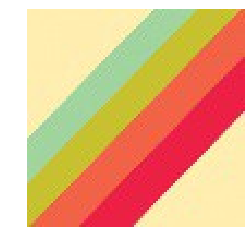

In [57]:
img = cv2.imread('../local_files/images/colors.jpeg')

# convert from BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis('off')
plt.imshow(img)

Looking at the image above, it's easy to see it is composed predominately of 5 colors, we can basically do the 'clustering' in our heads. To help visualize the clusters, we can plot every pixel in the image in an rgb color space. It's still fairly easy to see which pixels we would include in each cluster

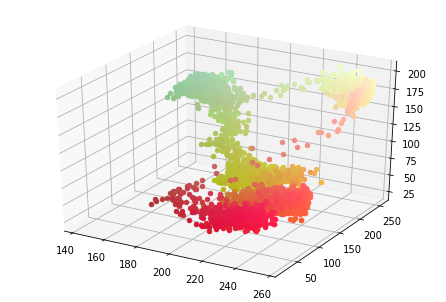

In [3]:
#get rgb values from image to 1D array
r, g, b = cv2.split(img)
r = r.flatten()
g = g.flatten()
b = b.flatten()

def rgb_to_hex(r, g, b):
    return '#%02x%02x%02x' % (int(r), int(g), int(b))

#plotting 
fig = plt.figure()
ax = Axes3D(fig)
for x in range(len(r)):
    ax.scatter(r[x], g[x], b[x], c=rgb_to_hex(r[x], g[x], b[x]))
plt.show()

# free memory
del r,g,b

## Clustering

We can use KMeans from scikit-learn to avoid writting a clustering algorithm ourselves. These functions cluster the data into a given number of clusters (`num_clust`), and then replace the color of every pixel in the cluster with the 'center' pixel, or the pixel who's color is most representative of the cluster.

In [5]:
def do_kmeans(img, num_clust):
    # reshape to array of pixel color values
    X = img.reshape(-1,3)

    # convert to np.float32
    X = np.float32(X)

    # cluster data using kmeans
    KMeans(n_clusters=num_clust).fit(X)
    return kmeans

def kmeans_img(kmeans):
    # get labels & values of centerpoints
    # convert centers to unit8
    # unsigned 8bit --> max of 255
    centers = kmeans.cluster_centers_
    centers = np.uint8(centers)
    labels = kmeans.labels_

    res = centers[labels.flatten()]
    return res.reshape(img.shape)

**Images**

Lets try some clustering with the image below. It looks like there are still 5-6 dominant colors, but hundreds of non-dominant colors. Pixels of the same color are no longer all adjacent to each other.

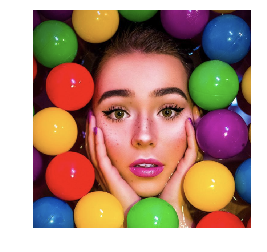

In [53]:
# read in & show image
img = cv2.imread('../local_files/images/balls.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis('off')
plt.imshow(img, interpolation='nearest')

Next, we will display an image for every number of clusters from 2-10. Since this image is predominantly composed of about 5 main colors, we can see the image only get marginally better from 6+ colors.

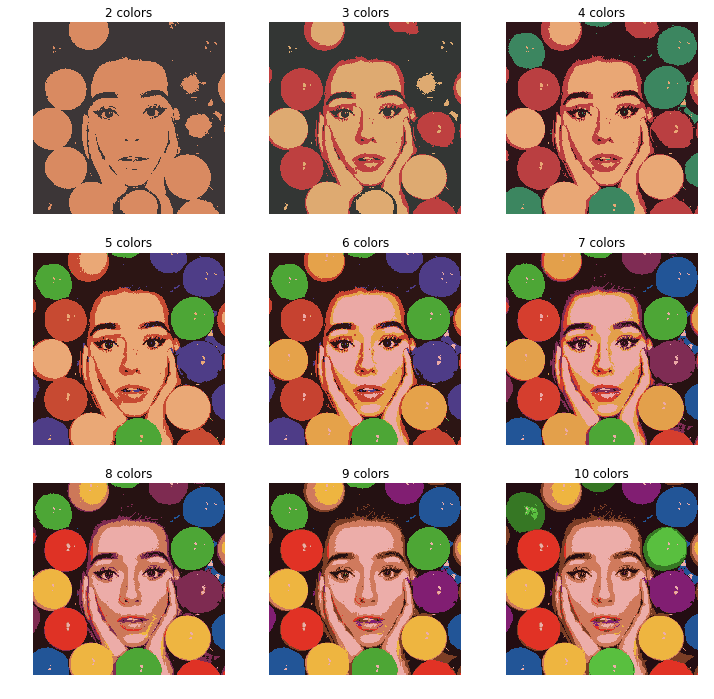

In [6]:
num_clusters = 2

fig, axs = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(12,12))
for ax in axs.flat:
        ax.set_title(str(num_clusters) + ' colors')
        ax.imshow(kmeans_img(do_kmeans(img, num_clusters)), interpolation='nearest')
        ax.axis('off')
        num_clusters += 1

plt.show()

Another cool thing we can do is plot a histogram representative of the number of pixels in each cluster. This can help us get a better sense of the dominant colors in images.

In [7]:
def show_hist(kmeans):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(kmeans.labels_)) + 1)
    hist, _ = np.histogram(kmeans.labels_, bins = numLabels)
 
    # normalize histogram
    hist = np.float32(hist)
    hist /= hist.sum()
    
    # initialize the bar chart representing the relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    start = 0
 
    # loop over the percentage of each cluster and the color of
    # each cluster
    for (percent, color) in zip(hist, kmeans.cluster_centers_):
        # plot the relative percentage of each cluster
        end = start + (percent * 300)
        cv2.rectangle(bar, (int(start), 0), (int(end), 50),
            color.astype('uint8').tolist(), -1)
        start = end
    
    plt.axis('off')
    plt.imshow(bar)
    plt.show()

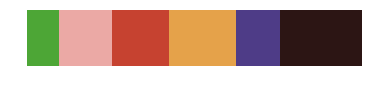

In [8]:
show_hist(do_kmeans(img, 6))

This historgram above almost gives us a 'color pallete' of the image's most dominant colors

### Video Processing

In [51]:
# read in video
cap = cv2.VideoCapture('../local_files/images/blade_runner240p.mp4')
frames = []

while(True):
    ret, frame = cap.read()
    if ret:
        # append each frame to frames array
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    else:
        break
        
cap.release()

In [66]:
def frame_avg_color(frames):
    # set img size based on frame count
    img_x = len(frames)
    img_y = int(img_x / 2)
    
    # create blank image
    bar = np.zeros((img_y, img_x, 3), np.uint8)
    x = 0

    # create a line as the avg color of each frame
    for frame in frames:
        avg_c = np.mean(frame.reshape(-1, 3), axis=0)
        cv2.line(bar, (x, 0), (x, img_y), avg_c, 1)
        x += 1

    plt.figure(figsize=(10,20))
    plt.axis('off')
    plt.imshow(bar)

We can read in a video as an arry of individual images.

To visualize the video's shift in color over time, we can plot the average color of each frame in the video. This video is the trailer for Blade Runner 2049.

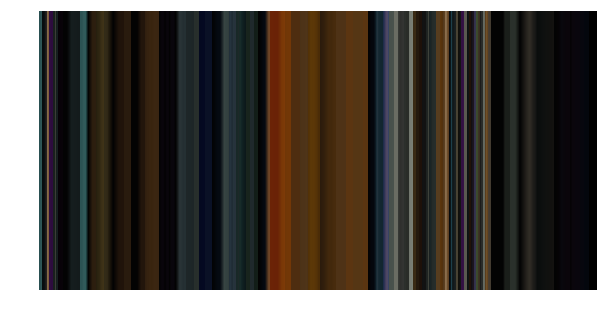

In [67]:
frame_avg_color(frames)

Instead of looking at every frame, we can run KMeans again, which will give us the 'color pallete' of the whole video

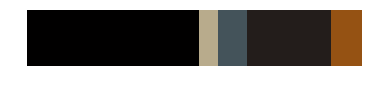

In [52]:
# combine individual frames together into a single large image
# taking every 10th frame to use less memory
frames_img = np.concatenate(frames[::10], axis=0)

show_hist(do_kmeans(frames_img, 5))